In [1]:
!pip install tensorflow librosa numpy pandas scikit-learn

  Using cached librosa-0.10.2.post1-py3-none-any.whl.metadata (8.6 kB)
  Using cached cffi-1.17.1-cp311-cp311-win_amd64.whl.metadata (1.6 kB)
Using cached librosa-0.10.2.post1-py3-none-any.whl (260 kB)
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   - -------------------------------------- 0.8/15.8 MB 4.8 MB/s eta 0:00:04
   ----- ---------------------------------- 2.1/15.8 MB 5.9 MB/s eta 0:00:03
   -------- ------------------------------- 3.4/15.8 MB 6.1 MB/s eta 0:00:03
   ----------- ---------------------------- 4.7/15.8 MB 6.1 MB/s eta 0:00:02
   --------------- ------------------------ 6.0/15.8 MB 6.1 MB/s eta 0:00:02
   ------------------ --------------------- 7.3/15.8 MB 6.1 MB/s eta 0:00:02
   --------------------- ------------------ 8.7/15.8 MB 6.2 MB/s eta 0:00:02
   ------------------------- -------------- 10.0/15.8 MB 6.1 MB/s eta 0:00:01
   ---------------------------- ----------- 11.3/15.8 MB 6.2 MB/s eta 0:00:01
   ------------------------------

In [ ]:
!pip install librosa --force-reinstall

In [1]:
import librosa
import numpy as np

def extract_mfcc(file_path, n_mfcc=13):
    """Extract MFCC features from an audio file."""
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return mfcc.T  # Transpose to get time steps in rows


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import InputLayer

def build_tcn_model(input_shape, num_classes):
    model = Sequential()

    # Input Layer
    model.add(InputLayer(input_shape=input_shape))

    # Temporal Convolutional Layer 1
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'))
    model.add(BatchNormalization())

    # Temporal Convolutional Layer 2
    model.add(Conv1D(filters=128, kernel_size=3, padding='causal', activation='relu'))
    model.add(BatchNormalization())

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [3]:
import os

def load_data_from_folders(parent_folder):
    file_paths = []
    labels = []

    # Traverse through all folders and collect file paths and labels
    for animal_folder in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, animal_folder)

        # Ensure we're only processing directories (one per animal)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(folder_path, file_name)
                    file_paths.append(file_path)
                    labels.append(animal_folder)  # The label is the folder name (e.g., 'dog', 'cat')

    return file_paths, labels

# Example usage:
parent_folder = "C:/Users/Vimal MR/Documents/Animal Sound Classification - Final Year Project/data"
file_paths, labels = load_data_from_folders(parent_folder)

# Check what you got
print(file_paths)  # List of all .wav file paths
print(labels)      # Corresponding animal labels


['C:/Users/Vimal MR/Documents/Animal Sound Classification - Final Year Project/data\\Cat\\cat_1.wav', 'C:/Users/Vimal MR/Documents/Animal Sound Classification - Final Year Project/data\\Cat\\cat_10.wav', 'C:/Users/Vimal MR/Documents/Animal Sound Classification - Final Year Project/data\\Cat\\cat_100.wav', 'C:/Users/Vimal MR/Documents/Animal Sound Classification - Final Year Project/data\\Cat\\cat_101.wav', 'C:/Users/Vimal MR/Documents/Animal Sound Classification - Final Year Project/data\\Cat\\cat_102.wav', 'C:/Users/Vimal MR/Documents/Animal Sound Classification - Final Year Project/data\\Cat\\cat_103.wav', 'C:/Users/Vimal MR/Documents/Animal Sound Classification - Final Year Project/data\\Cat\\cat_104.wav', 'C:/Users/Vimal MR/Documents/Animal Sound Classification - Final Year Project/data\\Cat\\cat_105.wav', 'C:/Users/Vimal MR/Documents/Animal Sound Classification - Final Year Project/data\\Cat\\cat_106.wav', 'C:/Users/Vimal MR/Documents/Animal Sound Classification - Final Year Proje

In [4]:
def pad_sequences(sequences, max_len):
    """Pad MFCC sequences with zeros to ensure the same length for all inputs."""
    padded_sequences = []
    for sequence in sequences:
        # Pad sequence with zeros if it is shorter than max_len
        if len(sequence) < max_len:
            padding = np.zeros((max_len - len(sequence), sequence.shape[1]))
            padded_sequence = np.vstack((sequence, padding))
        else:
            padded_sequence = sequence
        padded_sequences.append(padded_sequence)
    return np.array(padded_sequences)

# Example: Load the MFCCs for all files and pad them to the same length
X = [extract_mfcc(file_path) for file_path in file_paths]

# Define a maximum length for padding (e.g., based on the longest sample in your dataset)
max_len = max([len(mfcc) for mfcc in X])  # Get the length of the longest sample
print(max_len)


562


In [5]:
def trim_sequences(sequences, max_len):
    """Trim sequences to ensure they don't exceed max_len."""
    trimmed_sequences = []
    for sequence in sequences:
        if len(sequence) > max_len:
            trimmed_sequence = sequence[:max_len]
        else:
            trimmed_sequence = sequence
        trimmed_sequences.append(trimmed_sequence)
    return np.array(trimmed_sequences)


In [6]:
def split_sequence(sequence, chunk_size, overlap=0.5):
    """Split a sequence into smaller chunks with overlap."""
    step = int(chunk_size * (1 - overlap))  # Step size for overlapping
    chunks = [sequence[i:i+chunk_size] for i in range(0, len(sequence) - chunk_size + 1, step)]
    return np.array(chunks)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Define a maximum length for trimming and padding
max_len = 562  # Set to a reasonable number based on dataset

# Load and preprocess audio data
def load_data(file_paths, labels, n_mfcc=13):
    X, y = [], []

    for i, file_path in enumerate(file_paths):
        mfcc = extract_mfcc(file_path, n_mfcc=n_mfcc)
        X.append(mfcc)
        y.append(labels[i])

    # Ensure all inputs are of the same length
    X = np.array([np.pad(x, ((0, max_len - len(x)), (0, 0)), mode='constant') for x in X])

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    y = to_categorical(y)

    return X, y, label_encoder

# Load the MFCC features for all files
X, y, label_encoder = load_data(file_paths, labels)

# Pad and trim sequences to the same length
X_preprocessed = pad_sequences(X, max_len)
X_preprocessed = trim_sequences(X_preprocessed, max_len)

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build and train the TCN model
model = build_tcn_model(input_shape=(max_len, X_train.shape[2]), num_classes=y_train.shape[1])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)



C:\Users\Vimal MR\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.5816 - loss: 8.4986 - val_accuracy: 0.6410 - val_loss: 22.5311
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.8374 - loss: 1.4139 - val_accuracy: 0.7821 - val_loss: 8.9902
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.9024 - loss: 0.7473 - val_accuracy: 0.7051 - val_loss: 9.6825
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.9434 - loss: 0.2858 - val_accuracy: 0.7308 - val_loss: 8.8797
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.9256 - loss: 0.3803 - val_accuracy: 0.7051 - val_loss: 7.4550
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9719 - loss: 0.0980 - val_accuracy: 0.7051 - val_loss: 5.7971
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.9789 - loss: 0.2674 - val_accuracy: 0.7821 - val_loss: 3.2318
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9633 - loss: 0.1333 - val_accuracy: 0

In [8]:
# Predict labels for the test data
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compare predicted labels to true labels
accuracy = np.mean(y_pred_labels == y_true_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Accuracy: 85.90%


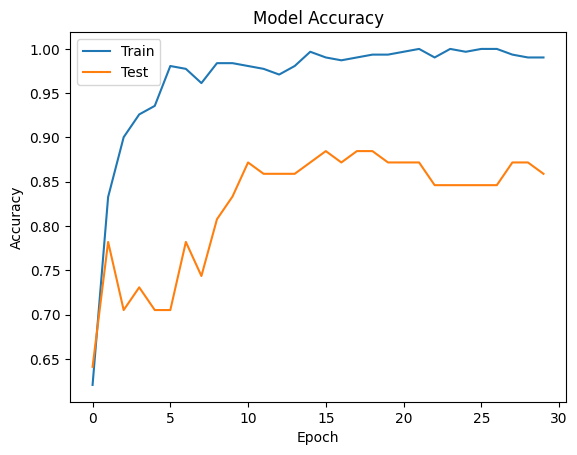

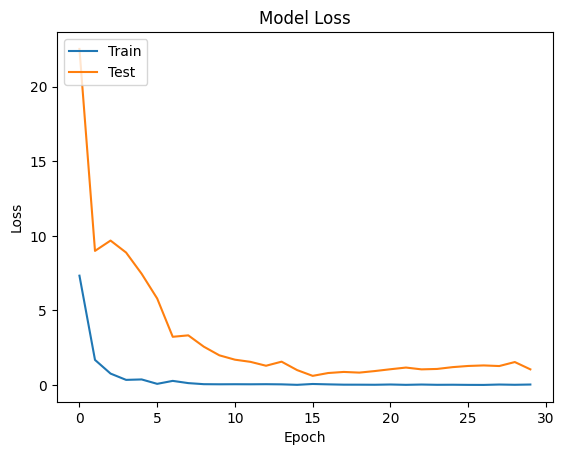

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [10]:
def predict_animal_sound(model, file_path, label_encoder):
    """Predict the class of a given audio file."""
    mfcc = extract_mfcc(file_path)
    mfcc = np.pad(mfcc, ((0, max_len - len(mfcc)), (0, 0)), mode='constant')
    mfcc = mfcc[np.newaxis, ...]  # Add batch dimension

    prediction = model.predict(mfcc)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label

# Example
predicted_animal = predict_animal_sound(model, 'C:/Users/Vimal MR/Documents/Animal Sound Classification - Final Year Project/data/dog_6.wav', label_encoder)
print(f"Predicted Animal Sound: {predicted_animal}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Animal Sound: ['Dog']


In [11]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Predict labels for the test data
y_pred = model.predict(X_test)

# Step 2: Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)  # Predicted class indices
y_true_labels = np.argmax(y_test, axis=1)  # True class indices

# Step 3: Use classification_report to find precision, recall, and F1 score
report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_)

# Print the classification report
print(report)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
              precision    recall  f1-score   support

         Cat       0.93      0.84      0.88        49
         Dog       0.76      0.90      0.83        29

    accuracy                           0.86        78
   macro avg       0.85      0.87      0.85        78
weighted avg       0.87      0.86      0.86        78

